In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
import time
import gc
from tqdm import trange

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 0)
pd.set_option('display.max_columns', 0)

# Load Data and Preprocessing

## UNSW-NB15

In [2]:
# Load Data
train_raw = pd.read_csv('../Data/UNSW_NB15/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/UNSW_NB15/test.csv')
print(test_raw.shape)
# Seperate label and drop unnecessary features
train_X = train_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw['label']
test_X = test_raw.drop(['id', 'attack_cat', 'label'], axis=1).select_dtypes(include='number')
print(test_X.shape)
test_Y = test_raw['label']

(82332, 45)
(175341, 45)
(82332, 39)
(175341, 39)


## NSL-KDD

In [2]:
# Load Data
train_raw = pd.read_csv('../Data/NSL_KDD/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/NSL_KDD/test.csv')
print(test_raw.shape)

# Seperate label and Drop ID
def LabelEncode(x):
    if x == 'normal':
        return 0
    else:
        return 1
train_X = train_raw.drop(['class'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw['class'].apply(LabelEncode)
test_X = test_raw.drop(['class'], axis=1).select_dtypes(include='number')
print(test_X.shape)
test_Y = test_raw['class'].apply(LabelEncode)

(125973, 42)
(22544, 42)
(125973, 38)
(22544, 38)


## CICIDS-2017

In [2]:
# Load Data
train_raw = pd.read_csv('../Data/CICIDS_2017/train.csv')
print(train_raw.shape)
test_raw = pd.read_csv('../Data/CICIDS_2017/test.csv')
print(test_raw.shape)

# Seperate label and Drop ID
def LabelEncode(x):
    if x == 'BENIGN':
        return 0
    else:
        return 1
train_X = train_raw.drop(['Unnamed: 0.1', 'Unnamed: 0', ' Label'], axis=1).select_dtypes(include='number')
print(train_X.shape)
train_Y = train_raw[' Label'].apply(LabelEncode)
test_X = test_raw.drop(['Unnamed: 0.1', 'Unnamed: 0', ' Label'], axis=1).select_dtypes(include='number')
print(test_X.shape)
test_Y = test_raw[' Label'].apply(LabelEncode)

(500000, 81)
(500000, 81)
(500000, 78)
(500000, 78)


# Feature Selection

In [3]:
# Normalize data with min, max of training data
test_X1 = (test_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))
train_X1 = (train_X - train_X.min(axis=0)) / (train_X.max(axis=0) - train_X.min(axis=0))

test_X1[test_X1 < 0] = 0
test_X1[test_X1 > 1] = 1

train_X1.fillna(0, inplace=True)
test_X1.fillna(0, inplace=True)

In [4]:
# correlation based feature selection
corr = train_X1.corr().abs()

correlation_threshold = 0.8
corr.values[np.tril_indices_from(corr.values)] = np.nan
redundant = []
for j in corr.columns:
    for i in corr.index:
        if corr.loc[i, j] > correlation_threshold:
            redundant.append((i, j))

train_corr = train_X1.copy()
train_corr['Label'] = train_Y
corr2 = train_corr.corr().abs()

corr3 = corr2['Label'].iloc[:-1].copy()
drop = []

# drop features having lower correlation with label
for i, j in redundant:
    if corr3[i] > corr3[j]:
        if j not in drop:
            drop.append(j)
    elif i not in drop:
        drop.append(i)
print(drop)

del corr, train_corr, corr2, corr3
gc.collect()

train_X1 = train_X1.drop(drop, axis=1)
print(train_X1.shape)
test_X1 = test_X1.drop(drop, axis=1)
print(test_X1.shape)

[' Total Backward Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Std', ' Bwd Packet Length Mean', 'Bwd Packet Length Max', ' Flow IAT Std', ' Flow Duration', ' Fwd IAT Mean', ' Flow IAT Max', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Max', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'Fwd PSH Flags', ' Fwd URG Flags', ' RST Flag Count', ' Average Packet Size', ' Fwd Packet Length Mean', ' Avg Bwd Segment Size', ' Fwd Header Length', ' Total Fwd Packets', 'Total Length of Fwd Packets', ' Subflow Bwd Packets', ' Subflow Bwd Bytes', ' act_data_pkt_fwd', ' Fwd Header Length.1', 'Active Mean', 'Idle Mean', ' Idle Max', ' Idle Min']
(500000, 42)
(500000, 42)


In [5]:
from sklearn.feature_selection import SelectKBest, SelectFromModel, RFE, SequentialFeatureSelector, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearnex import patch_sklearn, unpatch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [6]:
dataset_name = 'CICIDS_2017'
kf = StratifiedKFold(shuffle=True, random_state=0)
n_of_features = train_X1.shape[1]

In [7]:
# greedy search
greedy_all = []
score_functions = [chi2, f_classif, mutual_info_classif]
clfs = [GradientBoostingClassifier(n_estimators=200, random_state=0), RidgeClassifier(alpha=0.01, random_state=0)]
models = [GradientBoostingClassifier(n_estimators=200, random_state=0), RidgeClassifier(alpha=0.01, random_state=0)]

statistics_all = []
for sf in [chi2, f_classif, mutual_info_classif]:
    selector = SelectKBest(sf, k='all')
    selector.fit(train_X1, train_Y)
    sorted_index = np.argsort(selector.scores_)
    statistics_all.append(train_X1.columns[sorted_index])

for k in trange(n_of_features-1):
    features = []
    scores = []

    train_X2 = train_X1.drop(greedy_all, axis=1)
    for i in range(len(statistics_all)):
        f = statistics_all[i][0]
        
        for model in models:
            features.append(f)
            cv = cross_val_score(model, train_X2.drop([f], axis=1), train_Y, scoring='f1', cv=kf, n_jobs=-1)
            scores.append(cv.mean())
    
    for clf in clfs:
        selector = SequentialFeatureSelector(clf, direction='backward', n_features_to_select=train_X2.shape[1]-1, scoring='f1', cv=kf, n_jobs=-1)
        # select one best feature and add it to subset
        selector.fit(train_X2, train_Y)
        f = train_X2.columns[~selector.support_][0]
        for model in models:
            features.append(f)
            cv = cross_val_score(model, train_X2.drop([f], axis=1), train_Y, scoring='f1', cv=kf, n_jobs=-1)
            scores.append(cv.mean())

    for clf in clfs:
        selector = RFE(clf, n_features_to_select=train_X2.shape[1]-1)
        # select one best feature and add it to subset
        selector.fit(train_X2, train_Y)
        f = train_X2.columns[~selector.support_][0]
        
        for model in models:
            features.append(f)
            cv = cross_val_score(model, train_X2.drop([f], axis=1), train_Y, scoring='f1', cv=kf, n_jobs=-1)
            scores.append(cv.mean())

    for clf in clfs:
        
        selector = SelectFromModel(clf, threshold=-np.inf)
        # select one best feature and add it to subset
        selector.fit(train_X2, train_Y)
        if hasattr(selector.estimator_, 'coef_'):
            sorted_index = np.argsort(selector.estimator_.coef_).squeeze()
        elif hasattr(selector.estimator_, 'feature_importances_'):
            sorted_index = np.argsort(selector.estimator_.feature_importances_)
        f = train_X2.columns[sorted_index[0]]
        for model in models:
            features.append(f)
            cv = cross_val_score(model,  train_X2.drop([f], axis=1), train_Y, scoring='f1', cv=kf, n_jobs=-1)
            scores.append(cv.mean())
    
    best_score = np.max(scores)
    best_index = np.argmax(scores)
    best_feature = features[best_index]
    greedy_all.append(best_feature)
    for i in range(len(statistics_all)):
        statistics_all[i] = [j for j in statistics_all[i] if j != best_feature]
    # print(f'Select feature {best_feature} at iteration {k} with score {best_score:.2f}')

greedy_all.append(train_X1.columns.drop(greedy_all)[0])
print(greedy_all)

100%|██████████| 41/41 [92:25:14<00:00, 8114.99s/it]     

['Fwd IAT Total', ' Idle Std', ' Bwd PSH Flags', ' Flow Packets/s', ' Fwd Avg Packets/Bulk', ' ECE Flag Count', ' min_seg_size_forward', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', 'Flow Bytes/s', ' Bwd Avg Bytes/Bulk', 'Bwd Avg Bulk Rate', ' Bwd Header Length', ' Down/Up Ratio', ' Bwd IAT Std', ' Avg Fwd Segment Size', ' Active Std', ' Active Max', ' Fwd IAT Std', ' Fwd Packet Length Min', ' Active Min', ' CWE Flag Count', ' Min Packet Length', 'FIN Flag Count', ' Bwd IAT Min', ' URG Flag Count', ' Flow IAT Min', ' ACK Flag Count', ' SYN Flag Count', ' Bwd Packet Length Min', 'Fwd Packets/s', ' Bwd Packets/s', 'Subflow Fwd Packets', ' PSH Flag Count', ' Flow IAT Mean', ' Bwd Packet Length Std', ' Destination Port', ' Init_Win_bytes_backward', ' Subflow Fwd Bytes', 'Init_Win_bytes_forward']


In [8]:
greedy_all.reverse()
pd.DataFrame([greedy_all], index=['greedy']).to_csv('../Results/Paper/' + dataset_name + '/Greedy_Features.csv')

# Cross Validation and Test

## Linear Regression

In [9]:
# test with LR
model = RidgeClassifier(alpha=0.01, random_state=0)
cv_time = []
cv_f1 = []
test_time = []
test_f1 = []
for k in trange(n_of_features):
    # cross validation
    second = time.time()
    train_X2 = train_X1[greedy_all[:k+1]].copy()
    cv = cross_val_score(model, train_X2, train_Y, scoring='f1', cv=kf, n_jobs=-1)
    second2 = time.time()
    cv_time.append(second2 - second)
    cv_f1.append((cv.mean(), cv.std()))

    model.fit(train_X2, train_Y)
    second = time.time()
    predict = model.predict(test_X1[greedy_all[:k+1]])
    score = f1_score(test_Y, predict)
    second2 = time.time()
    test_time.append(second2 - second)
    test_f1.append(score)

100%|██████████| 42/42 [00:53<00:00,  1.28s/it]


In [10]:
pd.DataFrame([cv_time], index=['greedy']).to_csv('../Results/Paper/' + dataset_name + '/Greedy_CV_Time_LR.csv')
pd.DataFrame([cv_f1], index=['greedy']).to_csv('../Results/Paper/' + dataset_name + '/Greedy_CV_F1_LR.csv')
pd.DataFrame([test_time], index=['greedy']).to_csv('../Results/Paper/' + dataset_name + '/Greedy_Test_Time_LR.csv')
pd.DataFrame([test_f1], index=['greedy']).to_csv('../Results/Paper/' + dataset_name + '/Greedy_Test_F1_LR.csv')

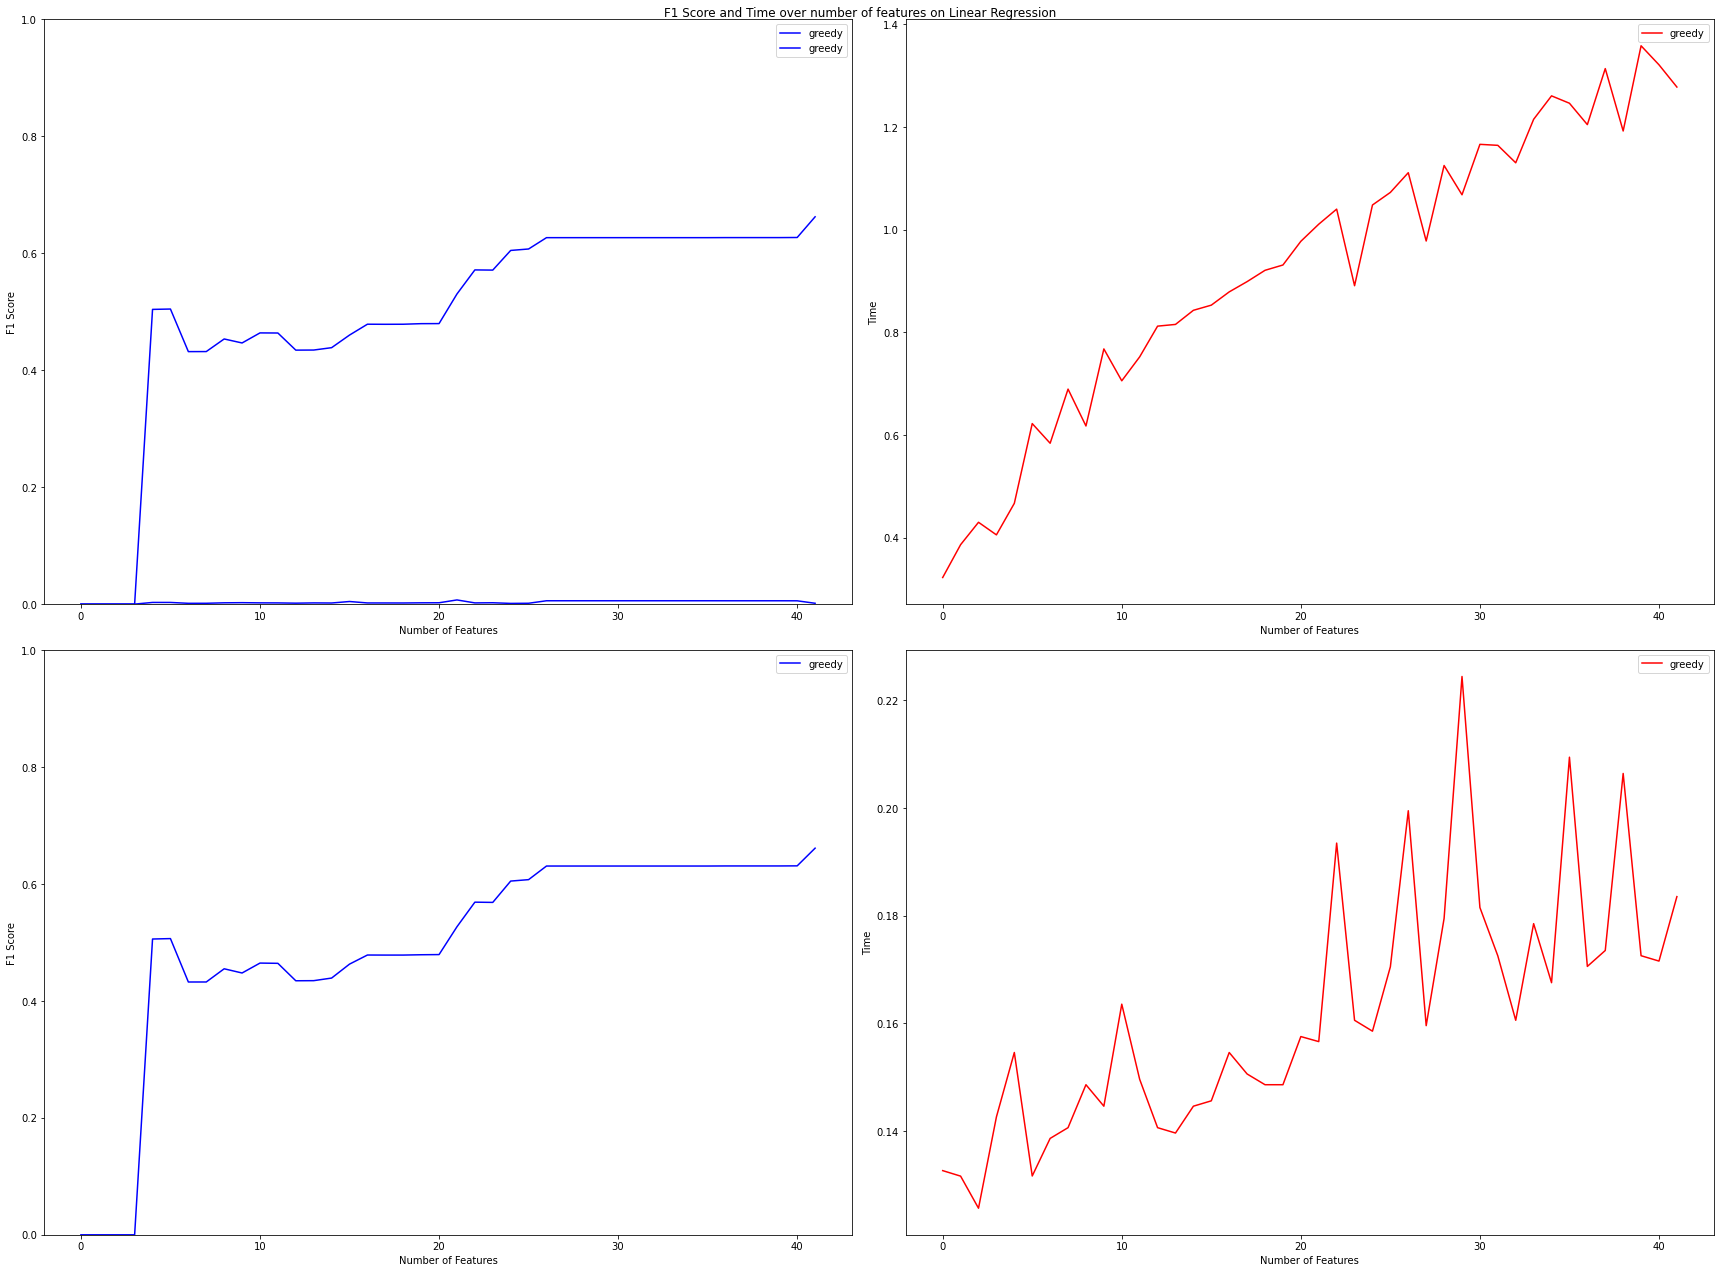

In [12]:
fig, axis = plt.subplots(2, 2, figsize=(24, 18))

plt.suptitle('F1 Score and Time over number of features on Linear Regression')
plt.subplot(2, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(n_of_features), cv_f1, color='blue', linestyle='-', label='greedy')

plt.legend()

plt.subplot(2, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(n_of_features), cv_time, color='red', linestyle='-', label='greedy')

plt.legend()

plt.subplot(2, 2, 3)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(n_of_features), test_f1, color='blue', linestyle='-', label='greedy')

plt.legend()

plt.subplot(2, 2, 4)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(n_of_features), test_time, color='red', linestyle='-', label='greedy')

plt.legend()

plt.tight_layout()
plt.savefig('../Evaluation/Paper/' + dataset_name + '/Greedy_LR.png')

## Gradient Boosting Decision Tree

In [13]:
# test with GB
model = GradientBoostingClassifier(n_estimators=200, random_state=0)
cv_time = []
cv_f1 = []
test_time = []
test_f1 = []
for k in trange(n_of_features):
    # cross validation
    second = time.time()
    train_X2 = train_X1[greedy_all[:k+1]].copy()
    cv = cross_val_score(model, train_X2, train_Y, scoring='f1', cv=kf, n_jobs=-1)
    second2 = time.time()
    cv_time.append(second2 - second)
    cv_f1.append((cv.mean(), cv.std()))

    model.fit(train_X2, train_Y)
    second = time.time()
    predict = model.predict(test_X1[greedy_all[:k+1]])
    score = f1_score(test_Y, predict)
    second2 = time.time()
    test_time.append(second2 - second)
    test_f1.append(score)

100%|██████████| 42/42 [3:52:54<00:00, 332.73s/it]  


In [14]:
pd.DataFrame([cv_time], index=['greedy']).to_csv('../Results/Paper/' + dataset_name + '/Greedy_CV_Time_GB.csv')
pd.DataFrame([cv_f1], index=['greedy']).to_csv('../Results/Paper/' + dataset_name + '/Greedy_CV_F1_GB.csv')
pd.DataFrame([test_time], index=['greedy']).to_csv('../Results/Paper/' + dataset_name + '/Greedy_Test_Time_GB.csv')
pd.DataFrame([test_f1], index=['greedy']).to_csv('../Results/Paper/' + dataset_name + '/Greedy_Test_F1_GB.csv')

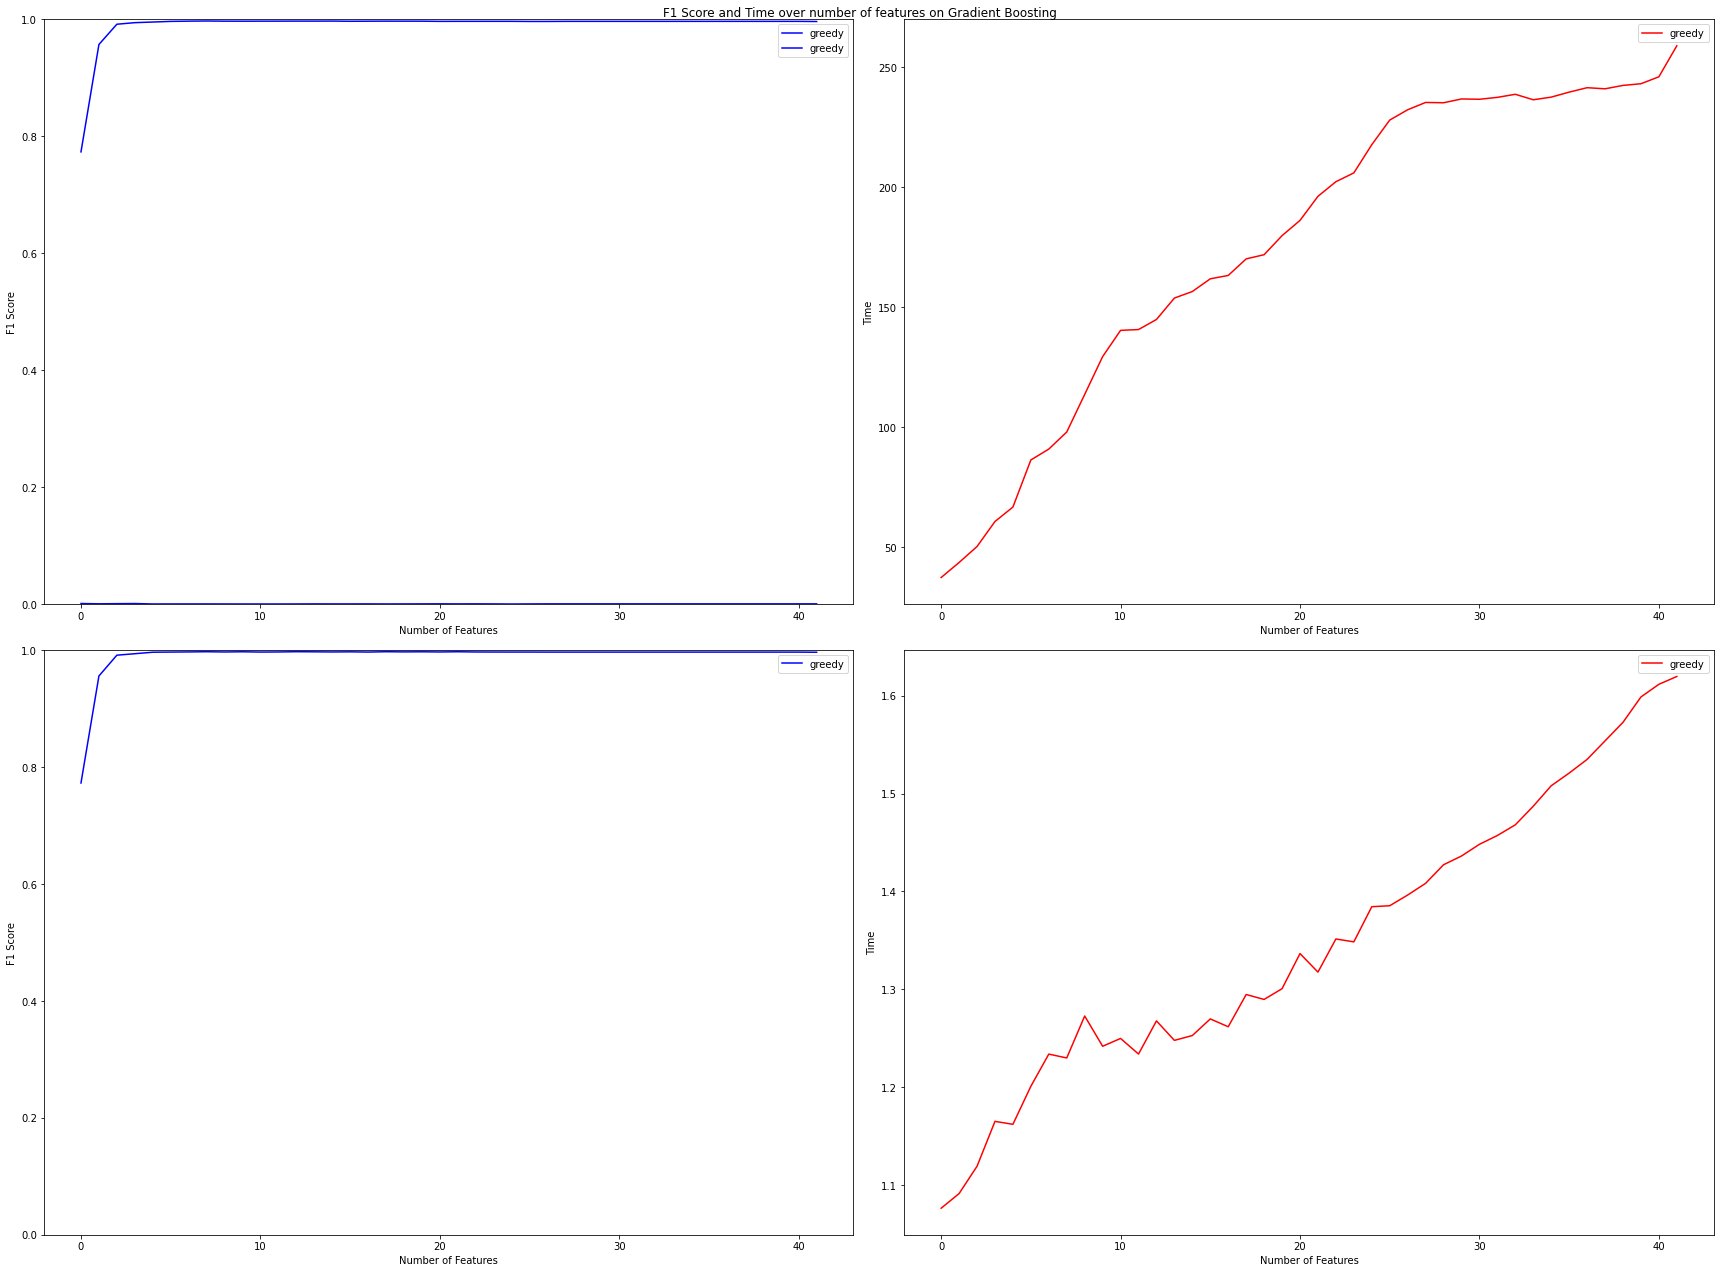

In [15]:
fig, axis = plt.subplots(2, 2, figsize=(24, 18))

plt.suptitle('F1 Score and Time over number of features on Gradient Boosting')
plt.subplot(2, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(n_of_features), cv_f1, color='blue', linestyle='-', label='greedy')

plt.legend()

plt.subplot(2, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(n_of_features), cv_time, color='red', linestyle='-', label='greedy')

plt.legend()

plt.subplot(2, 2, 3)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(n_of_features), test_f1, color='blue', linestyle='-', label='greedy')

plt.legend()

plt.subplot(2, 2, 4)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(n_of_features), test_time, color='red', linestyle='-', label='greedy')

plt.legend()

plt.tight_layout()
plt.savefig('../Evaluation/Paper/' + dataset_name + '/Greedy_GB.png')

## Neuron Network

In [16]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, optimizers, losses, metrics, callbacks

In [17]:
n_epoch = 15
batch_size = 100

In [18]:
def ModelCreate(input_shape):
    model = Sequential()
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu', input_shape=input_shape))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.Adam(), loss=losses.binary_crossentropy, metrics=[metrics.binary_accuracy])
    return model

In [19]:
cv_time = []
cv_f1 = []
test_time = []
test_f1 = []

for k in trange(n_of_features):
    model = ModelCreate((k+1,))
    # cross validation
    j = 0
    cv_time_ = 0
    cv = np.zeros(shape=5)
    train_X2 = train_X1[greedy_all[:k+1]].copy()
    for train_index, test_index in kf.split(train_X2, train_Y):
        x_train_fold, x_test_fold = train_X2.iloc[train_index, :], train_X2.iloc[test_index, :]
        y_train_fold, y_test_fold = train_Y.iloc[train_index], train_Y.iloc[test_index]

        second = time.time()
        model.fit(x_train_fold.values, y_train_fold.values,
                epochs=n_epoch, batch_size=batch_size,
                use_multiprocessing=True, verbose=0)
        predict = model.predict(x_test_fold, use_multiprocessing=True)
        predict = np.where(predict < 0.5, 0, 1)
        cv[j] = f1_score(y_test_fold, predict)
        second2 = time.time()
        cv_time_ += second2 - second
        j += 1
    cv_time.append(cv_time_)
    cv_f1.append((cv.mean(), cv.std()))

    second = time.time()
    model.fit(train_X1[greedy_all[:k+1]].values, train_Y.values,
            epochs=n_epoch, batch_size=batch_size,
            use_multiprocessing=True, verbose=0)
    predict = model.predict(test_X1[greedy_all[:k+1]], use_multiprocessing=True)
    predict = np.where(predict < 0.5, 0, 1)
    score = f1_score(test_Y, predict)
    second2 = time.time()

    test_time.append(second2-second)
    test_f1.append(score)

100%|██████████| 42/42 [15:10:41<00:00, 1301.00s/it]  


In [20]:
pd.DataFrame([cv_time], index=['greedy']).to_csv('../Results/Paper/' + dataset_name + '/Greedy_CV_Time_NN.csv')
pd.DataFrame([cv_f1], index=['greedy']).to_csv('../Results/Paper/' + dataset_name + '/Greedy_CV_F1_NN.csv')
pd.DataFrame([test_time], index=['greedy']).to_csv('../Results/Paper/' + dataset_name + '/Greedy_Test_Time_NN.csv')
pd.DataFrame([test_f1], index=['greedy']).to_csv('../Results/Paper/' + dataset_name + '/Greedy_Test_F1_NN.csv')

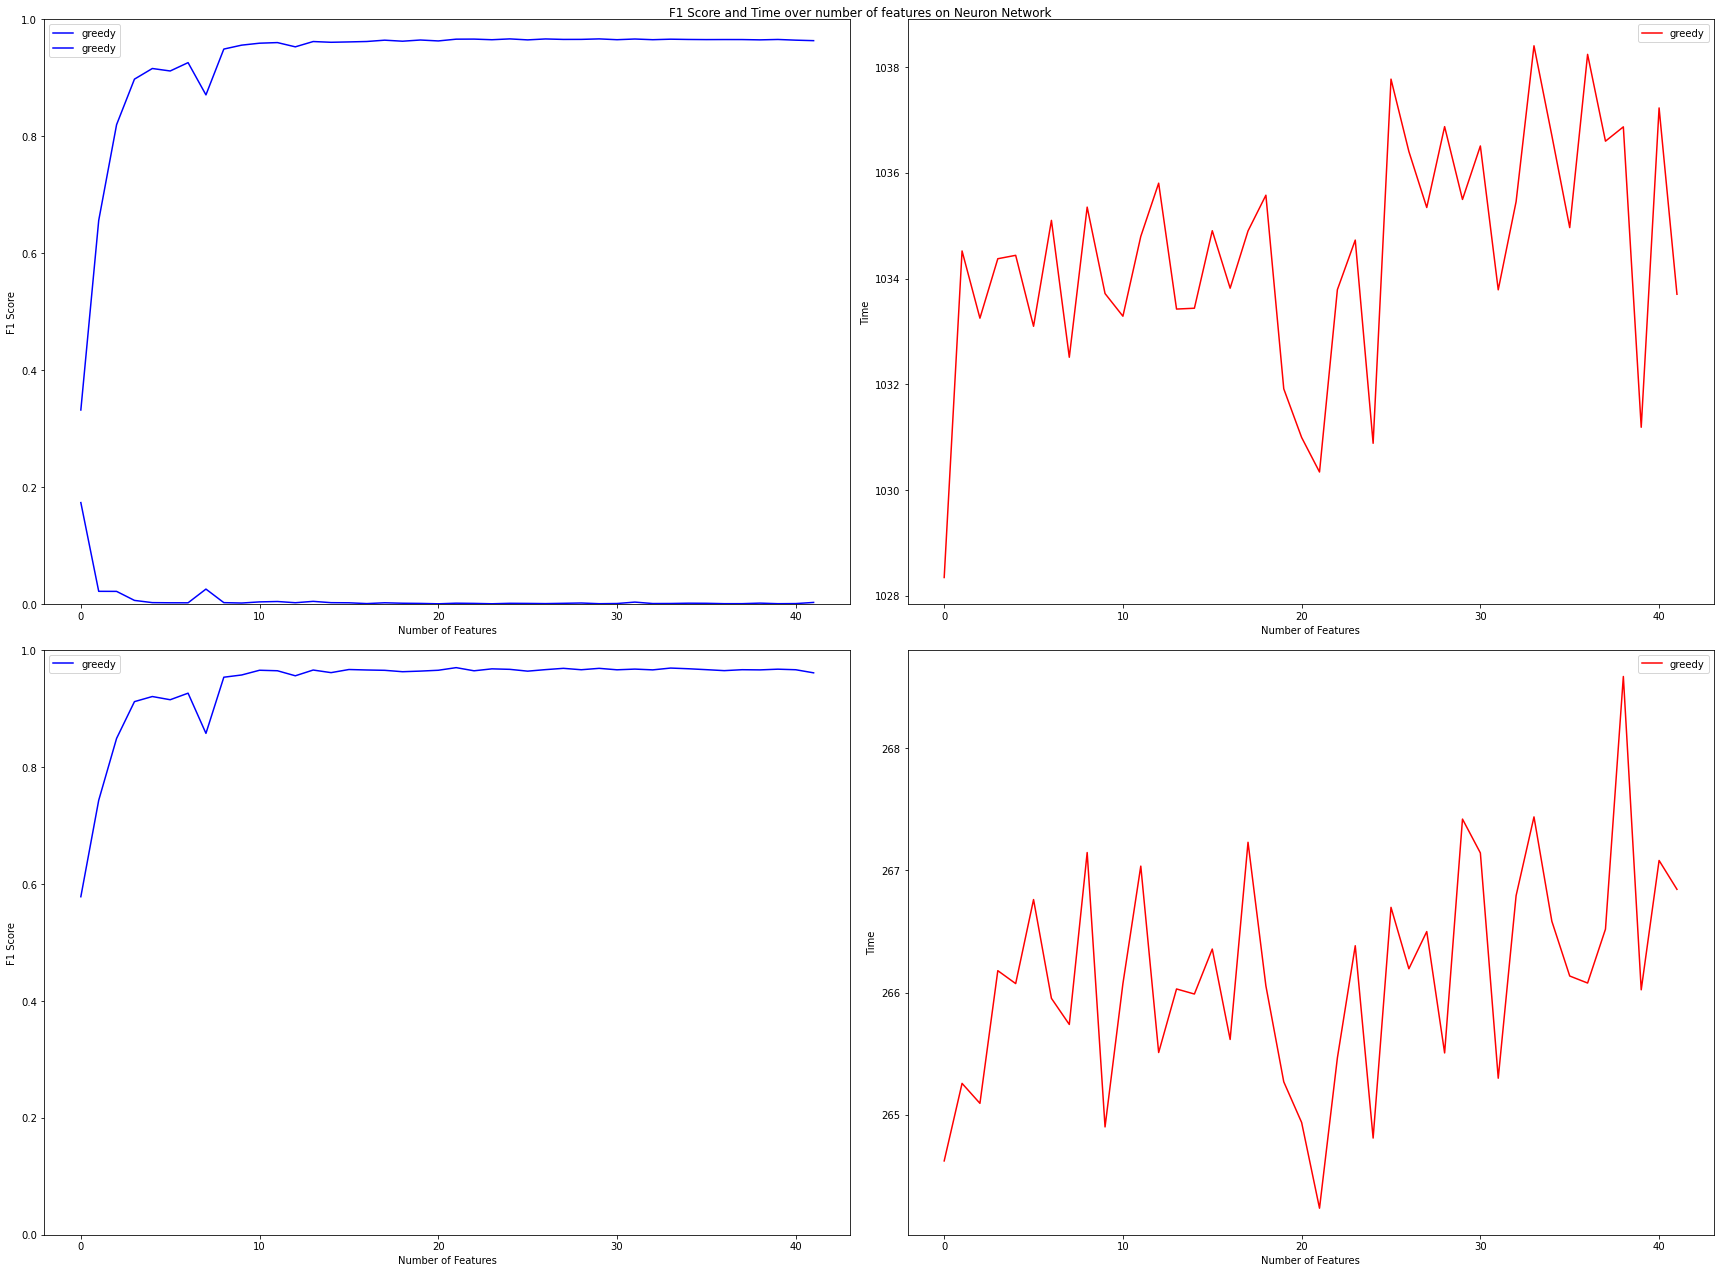

In [21]:
fig, axis = plt.subplots(2, 2, figsize=(24, 18))

plt.suptitle('F1 Score and Time over number of features on Neuron Network')
plt.subplot(2, 2, 1)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(n_of_features), cv_f1, color='blue', linestyle='-', label='greedy')

plt.legend()

plt.subplot(2, 2, 2)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(n_of_features), cv_time, color='red', linestyle='-', label='greedy')

plt.legend()

plt.subplot(2, 2, 3)
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.ylim((0, 1))

plt.plot(range(n_of_features), test_f1, color='blue', linestyle='-', label='greedy')

plt.legend()

plt.subplot(2, 2, 4)
plt.xlabel('Number of Features')
plt.ylabel('Time')

plt.plot(range(n_of_features), test_time, color='red', linestyle='-', label='greedy')

plt.legend()

plt.tight_layout()
plt.savefig('../Evaluation/Paper/' + dataset_name + '/Greedy_NN.png')